#Recurrent CNN for the surrogate modeling of subsurface flow simulation

This simple example demonstrates the performance of ConvLSTM-SegNet for surrogate modeling of flow simulation. 

The proposed method is desingned to reflect the time dependent property of simulation data.

The details and more complicated cases can be found in https://arxiv.org/pdf/2010.07747.pdf

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'cs231n_project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import scipy.io
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ConvED import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

Retrieve the simulation data (ECLIPSE) for traning, and split the data in
to training, validation, and test sets



In [ ]:
#Extract data
Nsteps = 30 # number of time steps 
Nx = 40 # x-direction grid number
Ny = 40 # y-direction grid number
N_samples = 3000; # number of samples in data 
A = scipy.io.loadmat('drive/My Drive/cs231n_project/1_3000.mat')
SAT_ = A['outputMatS_'].T  # saturation 
PERM_ = A['outputPerm_'].T # permeability
SAT_ = SAT_.reshape((N_samples,Nsteps+1,Nx,Ny))
PERM_ = PERM_.reshape((N_samples,Nx,Ny))
SAT_ = SAT_[:,1:Nsteps+1,:,:]
SAT = SAT_[:,:,:,:,np.newaxis]
PERM = PERM_[:,:,:,np.newaxis]
num_samples = PERM.shape[0]
train_ratio, val_ratio, test_ratio = 0.85, 0.1, 0.05  # Split data  
train_samples, val_samples, test_samples = int(train_ratio*num_samples), int(val_ratio*num_samples), int(test_ratio*num_samples)
indices = np.random.permutation(num_samples)
training_idx, validation_idx, test_idx = indices[:train_samples], indices[train_samples:train_samples+val_samples], indices[train_samples+val_samples:]
y_train, y_val, y_test = SAT[training_idx,:,:,:,:], SAT[validation_idx,:,:,:,:], SAT[test_idx,:,:,:,:] # output: y 
x_train, x_val, x_test = PERM[training_idx,:,:], PERM[validation_idx,:,:], PERM[test_idx,:,:] # input: x


Define three different loss functions: data loss, physical loss, and total loss for physics informed learning


In [ ]:
# measure the data misfit ( mean squre error loss )
def dataLoss(yTrue, yPred): 
  return tf.reduce_mean(tf.square(tf.subtract(yTrue,yPred)))

# measure the physical violation (residual)
def PhysicsLoss(yTrue, yPred): 
  A = yPred[:, 1:Ntsteps, :, :, :] - yPred[:, 0:Ntsteps-1, :, :, :]
  A = tf.reduce_sum(A, axis=(2,3),keepdims=True) # mass flow at the flow 
  B = yPred[:,1:Ntsteps,Nx-1:Nx,Ny-1:Ny,:] # mass flow at the well
  F = 1/(1+(B)/(1-B))  # fractional flow 
  residual = A/F  # mass balance residual 
  mean_residual = tf.reduce_mean(residual, axis=1, keepdims=True)
  return tf.reduce_mean(tf.abs(residual-mean_residual)/mean_residual)

# total loss : weight * physical loss + data misfit 
def totalLoss(yTrue, yPred):
  weight = 0
  mse = tf.keras.losses.MeanSquaredError()
  return weight * PhysicsLoss(yTrue, yPred) + mse(yTrue, yPred)

# Proposed method : ConvLSTM-SegNet
Here, we proposed ConvLSTM-SegNet to reflect the time dependent property of flow simulation. 


Build and train the ConvLSTM-SegNet model

In [ ]:
model1 = ConvEDLSTM(1, Nsteps-1, dropout_rate=0)
model1.build((None,Nx,Ny,1))
learning_rate = 5e-3
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=totalLoss,
              metrics=[tf.keras.metrics.MeanSquaredError(), PhysicsLoss])
callbacks = [
    ModelCheckpoint('best-weights1.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
]
history1 = model1.fit(x_train, y_train, batch_size=100, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

Test set error for trained ConvLSTM-SegNet model

In [ ]:
preds = model1.evaluate(x_test, y_test)
print ("Mean squared error = " + str(preds[1]))

# Basic method : SegNet


Build and train SegNet model

In [ ]:
SAT = np.transpose(SAT_, (0, 2, 3, 1))      # change the dimensions for plain ConvNet 
PERM = PERM_[:,:,:,np.newaxis]
y_train, y_val, y_test = SAT[training_idx,:,:,:], SAT[validation_idx,:,:,:], SAT[test_idx,:,:,:]
x_train, x_val, x_test = PERM[training_idx,:,:], PERM[validation_idx,:,:], PERM[test_idx,:,:]
model2 = ConvED(Nsteps, dropout_rate=0)     # build model
learning_rate = 1e-3
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
callbacks = [
    ModelCheckpoint('best-weights1.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
]
history2 = model2.fit(x_train, y_train, batch_size=100, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks) # train model

Test set error for trained SegNet

In [ ]:
preds = model2.evaluate(x_test, y_test)
print ("Mean squared error = " + str(preds[1]))

# Plot the results

First row: Proposed method (ConvLSTM-SegNet), 
Second row: SegNet, 
Third row: true data 

In [ ]:
def plot_tsteps(img, tsteps): 
  fig1 = plt.figure()
  for i in range(tsteps):
    plt.subplot(1,tsteps,i+1)
    im = plt.imshow(img[i,:,:])
    plt.xticks([0, 20, 40], ['0', '20', '40'])
    plt.yticks([0, 20, 40], ['0', '20', '40'])
    plt.clim(0, 1)  
    fig1.tight_layout() 

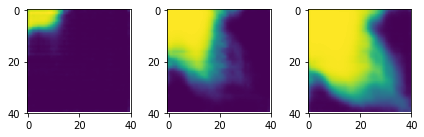

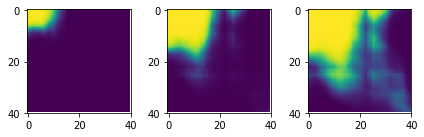

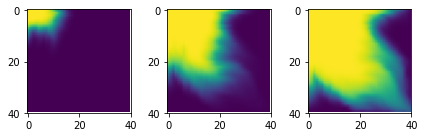

In [ ]:
SAT = SAT_[:,:,:,:,np.newaxis]
PERM = PERM_[:,:,:,np.newaxis]
y_test_LSTM = SAT[training_idx,:,:,:,:], SAT[validation_idx,:,:,:,:], SAT[test_idx,:,:,:,:]
x_test_LSTM = PERM[training_idx,:,:], PERM[validation_idx,:,:], PERM[test_idx,:,:]
y_predict_LSTM = model1.predict(x_test_LSTM)
y_predict_SegNet = model2.predict(x_test)
test_number = 3
tsteps = 3
plot_tsteps([y_predict_LSTM[test_number,i,:,:,0] for i in [0, 5, 10]], tsteps )
y_predict_SegNet = np.transpose(y_predict_SegNet, (0,3,1,2))
plot_tsteps([y_predict_SegNet[test_number,i,:,:] for i in [0, 5, 10]], tsteps )
y_true = np.transpose(y_test, (0,3,1,2))
plot_tsteps([y_true[test_number,i,:,:] for i in [0, 5, 10]], tsteps )